### Load base model

In [1]:
from ptlpinns.models import model, training, load
from ptlpinns.odes import forcing, numerical, equations
import numpy as np
import torch
import time

name = "undamped_nonlinear"
base_path = f"/home/dda24/PTL-PINNs/ptlpinns/models/train/{name}/"
base_name = f"model_{name}.pth"
base_model, training_log = model.load_model(base_path, base_name)

7 True True True 1.0 16 [256, 256, 512]


### Initialize transfer learning model

In [2]:
def transfer_model(training_log, base_model):

    bias = training_log['bias']
    use_sine = training_log['use_sine']
    use_fourier = training_log['use_fourier']
    scale = training_log['scale']
    n_frequencies = training_log['n_frequencies']
    hidden_layers = training_log['hidden_layers']

    if use_fourier:
        transfer_model = model.Multihead_model_fourier(k=1, bias=bias, use_sine=use_sine,
                                                use_fourier=use_fourier, scale=scale,
                                                n_frequencies=n_frequencies, HIDDEN_LAYERS=hidden_layers)
    else:
        transfer_model = model.Multihead_model_fourier(k=1, bias=bias, HIDDEN_LAYERS=hidden_layers)

    # Extract all layers except the final layers
    backbone = {k: v for k, v in base_model.state_dict().items() if not k.startswith("final_layers")}
    transfer_model.load_state_dict(backbone, strict=False)

    # freeze all layers except the final layers
    for name, param in transfer_model.named_parameters():
        if not name.startswith("final_layers"):
            param.requires_grad = False
    
    return transfer_model

In [3]:
transfer_model = transfer_model(training_log, base_model)

### Transfer learning parameters

In [4]:
w_transfer = [1]
zeta_transfer = [0]
q = 3
N = 512
t_span = (0, 15)
t_eval = np.linspace(t_span[0], t_span[1], N)
ic = [1, 0]
initial_condition_functions = [load.initial_condition(y1_0=ic[0], y2_0=ic[1])]
epsilon = 0.5
equation_functions = [equations.equation_oscillator(w_0=w_transfer[0], epsilon=epsilon)]
forcing_functions = [forcing.zeroes_2D(False)]

In [5]:
ode = equations.ode_oscillator_1D(w_0=w_transfer[0], zeta=zeta_transfer[0], forcing_1D = lambda t: np.zeros_like(t), q=q, epsilon=epsilon)
numerical_solution = numerical.solve_ode_equation(ode, (t_eval[0], t_eval[-1]), t_eval, ic)

### Training

In [6]:
def evaluate_MAE(transfer_model, numerical_solution):

    t_eval_torch = training.generate_eval_tensor(N, t_span, False)
    model_result = transfer_model(t_eval_torch)[0].squeeze()[:, 0].detach().numpy()
    return np.abs(np.mean(model_result - numerical_solution[0, :]))

In [7]:
def head_parameters(model, head_prefix="final_layers"):
    return [p for n, p in model.named_parameters() if n.startswith(head_prefix) and p.requires_grad]

In [8]:
def compute_transfer_learning(model, optimizer, num_iter, equation_functions, ic, forcing_functions, N=512, t_span=(0, 1),
                            every=100, ode_weight=1, ic_weight=1, method='equally-spaced-noisy'):

       for it in range(1, num_iter):

              optimizer.zero_grad()
              total, ode, ic, _ = training.loss(
              model=model, N=N, t_span=t_span,
              equation_functions=equation_functions,
              initial_condition_functions=initial_condition_functions,
              forcing_functions=forcing_functions,
              ode_weight=ode_weight, ic_weight=ic_weight, method=method)
              total.backward()
              optimizer.step()

              if it % every == 0:
                     print(f"[iteration] {it} | total {total.item():.3e} | ode {ode.item():.3e} | ic {ic.item():.3e}")

In [9]:
optimizer = torch.optim.Adam(head_parameters(transfer_model), lr=1e-2)
num_iter = 5000

In [10]:
compute_transfer_learning(transfer_model, optimizer, num_iter,
                        equation_functions, ic, forcing_functions,
                        N=N, t_span=t_span, every=200)

[iteration] 200 | total 5.292e-04 | ode 5.190e-04 | ic 1.027e-05
[iteration] 400 | total 3.685e-04 | ode 3.619e-04 | ic 6.652e-06
[iteration] 600 | total 2.869e-04 | ode 2.823e-04 | ic 4.665e-06
[iteration] 800 | total 2.349e-04 | ode 2.315e-04 | ic 3.437e-06
[iteration] 1000 | total 1.938e-04 | ode 1.911e-04 | ic 2.783e-06
[iteration] 1200 | total 1.620e-04 | ode 1.600e-04 | ic 2.081e-06
[iteration] 1400 | total 1.376e-04 | ode 1.363e-04 | ic 1.305e-06
[iteration] 1600 | total 1.148e-04 | ode 1.136e-04 | ic 1.221e-06
[iteration] 1800 | total 9.450e-05 | ode 9.383e-05 | ic 6.711e-07
[iteration] 2000 | total 7.805e-05 | ode 7.708e-05 | ic 9.793e-07
[iteration] 2200 | total 7.384e-05 | ode 6.304e-05 | ic 1.080e-05
[iteration] 2400 | total 1.800e-03 | ode 3.842e-04 | ic 1.416e-03
[iteration] 2600 | total 4.998e-05 | ode 4.934e-05 | ic 6.324e-07
[iteration] 2800 | total 4.566e-05 | ode 4.466e-05 | ic 9.978e-07
[iteration] 3000 | total 9.050e-05 | ode 5.196e-05 | ic 3.855e-05
[iteration] 32

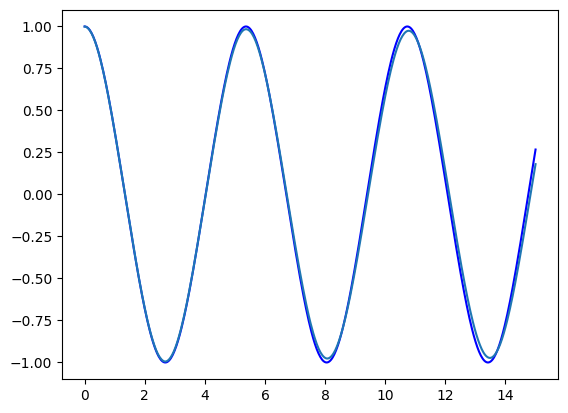

In [11]:
import matplotlib.pyplot as plt
plt.plot(t_eval, numerical_solution[0, :], label='Numerical Solution', color='blue')
plt.plot(t_eval, transfer_model(training.generate_eval_tensor(N, t_span, False))[0].squeeze()[:, 0].detach().numpy())